<a href="https://colab.research.google.com/github/tommycwong/ML-ElectronMicroscopy-2023/blob/main/Lecture%2013/ML4EM_Summer2023_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL for Microscopy: U-Net
Prepared by Tommy Wong, with sections adapted from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html and from Maxim Ziatdinov enabled by [AtomAI](https://github.com/pycroscopy/atomai). Data made available by Shradha Agarwal.

**To run this notebook, click Runtime -> Run all, and in Change runtime type slect a GPU. Make sure to specify filenames and uncomment cells according to instructions.**

---



---


This notebook show how to apply a UNet-like neural network for semantic segmentation of TEM images



Install AtomAI:

In [ ]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source

  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-_p22jefl
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-_p22jefl
  Resolved https://github.com/pycroscopy/atomai to commit 6d187296074143d017ca8fc60302364cd946b180
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 71.6 MB/s eta 0:00:00
  Created wheel for atomai: filename=atomai-0.7.8-py3-none-any.whl size=162558 sha256=c290a9398419da8993d73f1d6ffc181e16b8f37fd8178e5af2328541d9b23fe1
  Stored in directory: /tmp/pip-ephem-wheel-cache-joa4681n/wheels/ca/13/12/fc0f90d0fce48063154d2a5f9fc755aee641d61d21f58f1800
  Created wheel for 

Imports:

In [ ]:
# AtomAI implements U-Net
import atomai as aoi

import numpy as np
import matplotlib.pyplot as plt

It is important to normalize pixels to between 0 and 1 for training with a neural network. Here is a simple function for normalization of a single image:

In [ ]:
def norm2D(img):
    return (img - np.amin(img))/np.ptp(img)

## Generate training data

Download training image and label from GitHub. Mount Google Drive or use `!gdown` instead to access images on Google Drive. Augmentation has to be performed on both images and labels to ensure correspondance.

In [ ]:
# Training images
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_1.png'
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_2.png'
# Training labels
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Lab_1.xml'
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Lab_2.xml'

--2023-07-17 23:49:35--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157118 (153K) [image/png]
Saving to: ‘DL_for_Microscopy_Train_Img_1.png’

DL_for_Microscopy_T 100%[===================>] 153.44K  --.-KB/s    in 0.003s  

2023-07-17 23:49:36 (44.5 MB/s) - ‘DL_for_Microscopy_Train_Img_1.png’ saved [157118/157118]

--2023-07-17 23:49:36--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubu

Load, normalize, and show the training image and labels with size 512 by 512. The images have dimensions [N, H, W] where N is the number of images. Define a function that does that.

In [ ]:
# A function to generate a stack of images:
def get_imgs(file_list):
    imgs_ = []
    for name in file_list:
        imgs_.append(norm2D(plt.imread(name)))
    # move last axis to 1st so that 1st axis is no. of imgs
    return np.moveaxis(np.dstack(imgs_), -1, 0)

**Create a python list of your training images filenames here:**

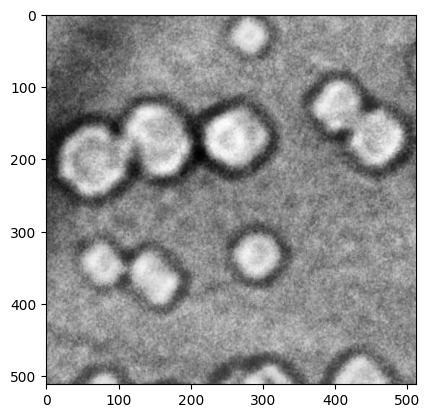

In [ ]:
# Change the filenames of this list to your training data:
train_img_names = ['DL_for_Microscopy_Train_Img_1.png', 'DL_for_Microscopy_Train_Img_2.png']

# Generate a stack of training images:
train_imgs = get_imgs(train_img_names)

# Show the training imgs:
plt.imshow(train_imgs[0], cmap='gist_gray')
plt.imshow(train_imgs[1], cmap='gist_gray')

Define a function to parse the `.xml` files. Takes image and labels filenames as lists and returns a list of annotations.

In [ ]:
#@title `.xml` parser
from lxml import etree

def parse_anno_file(cvat_xml, image_name):
    annos = []
    for i in range(len(cvat_xml)):
        root = etree.parse(cvat_xml[i]).getroot()
        anno = []
        image_name_attr = ".//image[@name='{}']".format(image_name[i])
        for image_tag in root.iterfind(image_name_attr):
                image = {}
                for key, value in image_tag.items():
                    image[key] = value
                image['shapes'] = []
                for poly_tag in image_tag.iter('polygon'):
                    polygon = {'type': 'polygon'}
                    for key, value in poly_tag.items():
                        polygon[key] = value
                    image['shapes'].append(polygon)
                for ell_tag in image_tag.iter('ellipse'):
                    ellipse = {'type': 'ellipse'}
                    for key, value in ell_tag.items():
                        ellipse[key] = value
                    image['shapes'].append(ellipse)
                for box_tag in image_tag.iter('box'):
                    box = {'type': 'box'}
                    for key, value in box_tag.items():
                        box[key] = value
                    box['points'] = "{0},{1};{2},{1};{2},{3};{0},{3}".format(
                        box['xtl'], box['ytl'], box['xbr'], box['ybr'])
                    image['shapes'].append(box)
                image['shapes'].sort(key=lambda x: int(x.get('z_order', 0)))
                anno.append(image)
        annos.append(anno)
    return annos

Parse the `.xml` file and show a sample annotation. **Type your image and labels filenames as lists.**

In [ ]:
xml = ['DL_for_Microscopy_Train_Lab_1.xml', 'DL_for_Microscopy_Train_Lab_2.xml']
annos = parse_anno_file(xml, train_img_names)
print(annos[0][0]) #[0][0] to show 1st img

{'id': '0', 'name': 'DL_for_Microscopy_Train_Img_1.png', 'width': '512', 'height': '512', 'shapes': [{'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '190.29,53.06;190.29,41.21;190.91,31.86;186.55,23.12;177.19,16.26;167.21,13.77;157.23,11.90;147.25,11.27;137.90,12.52;129.16,16.26;120.43,21.25;114.82,29.36;111.07,38.09;111.07,48.70;114.82,57.43;119.81,66.16;127.29,72.40;136.02,76.14;145.38,77.39;154.74,78.64;164.09,78.01;172.83,73.65;183.40,64.30', 'z_order': '0'}, {'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '99.85,57.43;96.10,48.70;94.86,39.34;97.97,29.99;101.09,20.63;108.58,14.39;117.94,13.14;127.29,11.27;137.27,11.27;146.00,15.02;154.74,18.76;162.22,25.00;164.09,34.35;162.22,43.71;157.23,52.44;152.24,61.17;146.63,69.91;136.02,76.77;127.90,76.10;118.56,73.02;106.10,66.20', 'z_order': '0'}, {'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '1.29,58.05;10.65,59.93;20.01,63.

Define functions that generate masks and datasets for U-Net:

In [ ]:
#@title Functions that generate masks and datasets for U-Net
# must include these modules for functions below
import cv2
import torch

# Creates a mask using parsed annotations. Can be used directly to create mask for U-Net
def create_mask(width, height, shapes):
    mask = np.zeros((height, width), dtype=np.uint8)
    for shape in shapes:
        if shape['type'] == 'polygon':
            points = [tuple(map(float, p.split(','))) for p in shape['points'].split(';')]
            points = np.array([(int(p[0]), int(p[1])) for p in points])
            points = points.astype(int)
            mask = cv2.drawContours(mask, [points], -1, color=1, thickness=-1)
        if shape['type'] == 'ellipse':
            center_coordinates = (int(float(shape['cx'])), int(float(shape['cy'])))
            axesLength = (int(float(shape['rx'])), int(float(shape['ry'])))
            if 'rotation' in shape:
                angle = int(shape['rotation'])
            else:
                angle = 0
            mask = cv2.ellipse(mask, center_coordinates, axesLength, angle,
                               startAngle=0, endAngle=360, color=1, thickness=-1)
    return mask

# Create mask for U-Net -> [N, H, W]
def get_unet_mask(annos):
    masks = []
    for anno in annos:
        mask = create_mask(int(anno[0]['width']), int(anno[0]['height']), anno[0]['shapes'])
        masks.append(mask)
    masks_np = np.dstack(masks)
    return np.moveaxis(masks_np, -1, 0)

### Process data for U-Net

Generate the labels for U-Net semantic segmentation. Masks have dimensions [N, H, W] and pixel values of either 0 (for background) and 1 (for features).

In [ ]:
unet_masks = get_unet_mask(annos)

Show the U-Net mask:

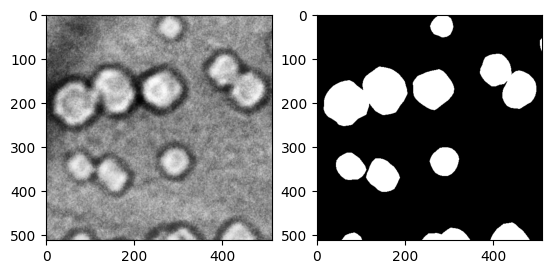

In [ ]:
#@title Show the mask for 1 image:

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_imgs[1], cmap='gist_gray')
ax[1].imshow(unet_masks[1], cmap='gist_gray')

###Data cropping

Define functions for cropping. Cropping using a sliding window allows small amount of microscopy data to be diversified into more data for training. Convolutional neural networks (CNNs) also do not perform well with extremely large images common in microscopy. `unet_cropper` is used for cropping data for U-Net.

In [ ]:
#@title Cropping functions:
import numpy as np

class cropper:
    """
    Augments an input image-mask pair by performing image cropping procedure
    """
    def __init__(self, image, mask, window_size, step_size):
        """
        Args:
            image (2d ndarray): image to be cropped (height x width),
            mask (3d ndarray): mask/ground truth (height x width x channels),
            window_size (tuple): width and height of sliding window,
            step_size (float): step size of sliding window,
            batch_size (int): number of images to return.
        """
        if np.ndim(image) == 2:
            image = np.expand_dims(image, axis=2)
        self.image = image
        if np.ndim(mask) == 2:
            mask = np.expand_dims(mask, axis=2)
        self.mask = mask
        self.window_size = window_size
        self.step_size = step_size

    def sliding_window(self):
        """
        Returns the portion of the input image lying within sliding window
        """
        for y in range(0, self.image.shape[0], self.step_size):
            for x in range(0, self.image.shape[1], self.step_size):
                yield (self.image[y:y + self.window_size[1], x:x + self.window_size[0], :],
                       self.mask[y:y + self.window_size[1], x:x + self.window_size[0], :])

    def imgen(self):
        """
        Returns a batch of cropped images and
        a batch of corresponding labels (ground truth)
        """
        X_batch = np.empty((0, self.window_size[0], self.window_size[1]))
        y_batch = []
        for window in self.sliding_window():
            if window[0].shape[: -1] != self.window_size:
                continue
            window_i = np.transpose(window[0], [2, 0, 1])   # img
            window_i = (window_i - np.amin(window_i))/np.ptp(window_i) # normalize img
            window_l = np.transpose(window[1], [2, 0, 1])   # lab
            # remove masks w/o bubbles
            window_l = window_l[np.any(window_l != 0, axis=(1, 2))]
            X_batch = np.append(X_batch, window_i, axis=0)
            y_batch.append(window_l)
        if len(X_batch) != len(y_batch):
            return 'no. of image patches does not match no. of label patches'
        return X_batch, y_batch

    def norm2D(img):
        return (img - np.amin(img))/np.ptp(img)

def unet_cropper(img, mask, window_size, step_size):
    """
    input:
    img, mask in np.array([N, H, W]) where N is no. of imgs/masks
    window_size, step_size: int, square windows with stride of step_size
    return:
    img_patches and lab_patches in np.array([N, H, W]) where N is no. of patches
    """
    img_patches = []; lab_patches = []
    for i in range(len(img)):
        imcrop = cropper(img[i], mask[i], (window_size, window_size), step_size)
        img_patch, lab_patch = imcrop.imgen()
        lab_patch = np.stack(lab_patch, axis=0)[:, 0, ...]
        img_patches.append(img_patch)
        lab_patches.append(lab_patch)
    return np.vstack(img_patches), np.vstack(lab_patches)

Show the U-Net masks:

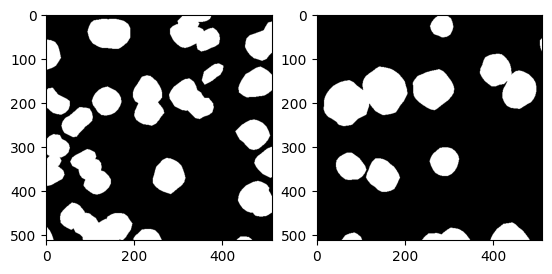

In [ ]:
# Show the masks:
fig, ax = plt.subplots(1, len(unet_masks))
for i in range(len(unet_masks)):
    ax[i].imshow(unet_masks[i], cmap='gist_gray')

Crop the U-Net images/masks into patches of 256 by 256 with step size/stride of 128 (half of window size):

In [ ]:
unet_img_patches, unet_mask_patches = unet_cropper(train_imgs, unet_masks, window_size=256, step_size=128)

Display a few cropped patches:

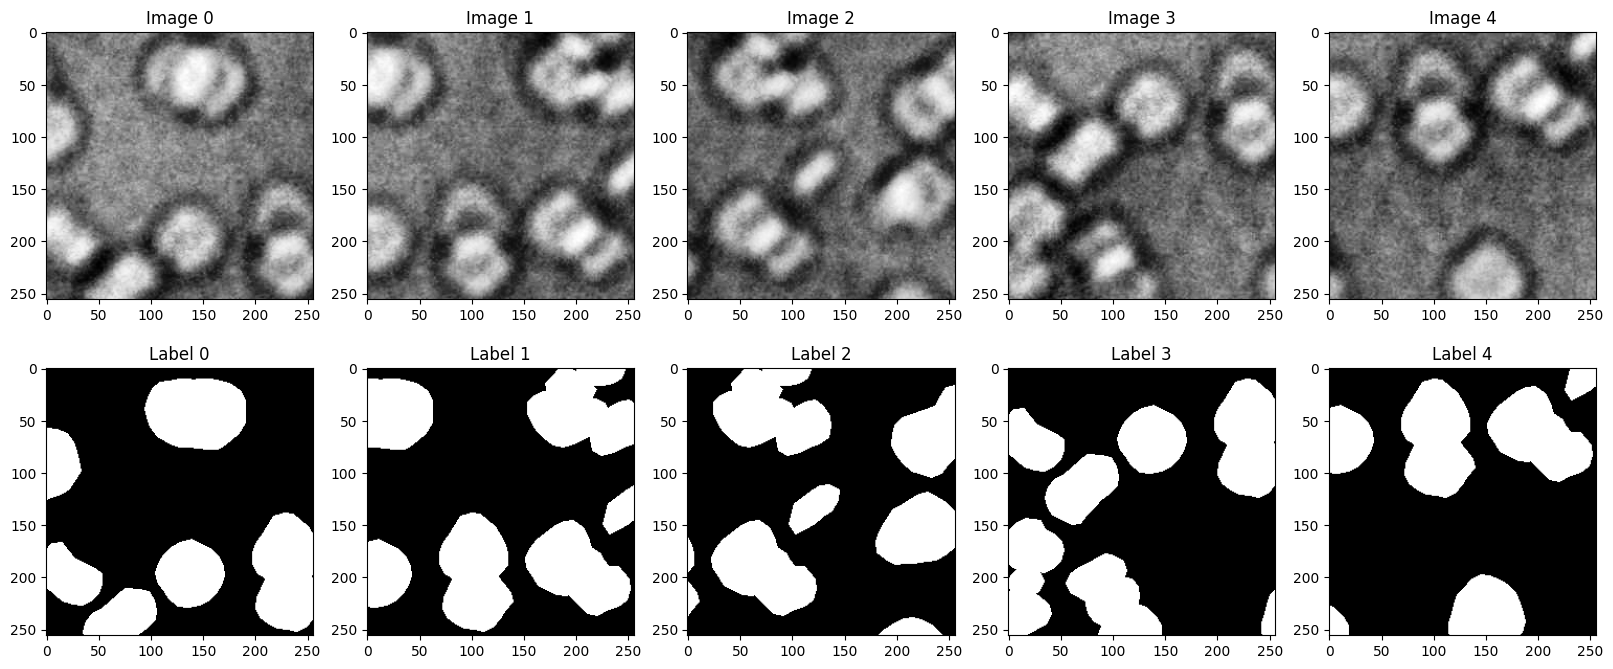

In [ ]:
#@title Show patches:
fig = plt.figure(figsize=(20, 8))
for i in range(1, 6):
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(unet_img_patches[i-1, ...], cmap='gist_gray')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, 5, i+5)
    ax.imshow(unet_mask_patches[i-1, ...], cmap='gist_gray')
    ax.set_title('Label ' + str(i-1))

###Data augmentation

Define functions for image augmentation. Adding noise that might be present in electron microscopy also allows small amount of microscopy data to be diversified into more data for training.

In [ ]:
#@title Augmentation functions:
import atomai as aoi
import torch
import random

def img_augmentor(images=None, labels=None, nb_classes=1, seed=0, **kwargs):
    '''
    return: augmented images, labels in np.array([N, H, W])
    input:
    images, labels in np.array([N, H, W])
    labels can be replaced with images to only augment images
    nb_classes = no. of classes in labels (default=1)
    kwargs:
    zoom = 1.3 # zoom factor
    poisson_noise = [30, 40] # P noise range (scaled units)
    gauss_noise = [0, 200] # G noise range (scaled units)
    blur = [1, 50] # Blurring range (scaled units)
    contrast = [5, 20] # contrast range (< 10 is brighter, > 10 is darker)
    salt_and_pepper = [0, 100] # min/max amount of salted/peppered pixels (scaled units)
    jitter = [0, 50]
    rotation=True
    background=True
    '''
    imaug = aoi.transforms.seg_augmentor(nb_classes=nb_classes, seed=seed, **kwargs)
    images_aug, labels_aug = imaug(torch.from_numpy(images[:, np.newaxis, ...]),
                                   torch.from_numpy(labels[:, np.newaxis, ...]), seed=seed)
    return images_aug.numpy()[:, 0, ...], labels_aug.numpy()[:, 0, ...]

def unet_augmentor(images=None, labels=None, batch_size=32, nb_classes=1, seed=0, **kwargs):
    '''
    return: augmented images, labels in np.array([N, H, W])
    input:
    images, labels in np.array([N, H, W])
    labels can be replaced with images to only augment images
    batch_size = no. of augmented images/labels generated (default=32)
    nb_classes = no. of classes in labels (default=1)
    kwargs:
    zoom = 1.3 # zoom factor
    poisson_noise = [30, 40] # P noise range (scaled units)
    gauss_noise = [0, 200] # G noise range (scaled units)
    blur = [1, 50] # Blurring range (scaled units)
    contrast = [5, 20] # contrast range (< 10 is brighter, > 10 is darker)
    salt_and_pepper = [0, 100] # min/max amount of salted/peppered pixels (scaled units)
    jitter = [0, 50]
    rotation=True
    background=True
    '''
    random.seed(seed)
    randidx = random.choices([*range(len(images))], k=batch_size)
    batch_shape = (batch_size, images.shape[1], images.shape[2])
    img_batch = np.zeros(batch_shape); lab_batch = np.zeros(batch_shape)
    for i in range(batch_size):
        img_batch[i] = images[randidx[i]]; lab_batch[i] = labels[randidx[i]]
    imaug = aoi.transforms.seg_augmentor(nb_classes=nb_classes, seed=seed, **kwargs)
    images_aug, labels_aug = imaug(torch.from_numpy(img_batch[:, np.newaxis, ...]),
                                   torch.from_numpy(lab_batch[:, np.newaxis, ...]), seed=seed)
    return images_aug.numpy()[:, 0, ...], labels_aug.numpy()[:, 0, ...]

### Augmenting U-Net images:

Augment U-Net images. Since the datset isn't that noisy only a low level of noise is added.

In [ ]:
rotation = True
gauss_noise = [0, 50] # G noise range (scaled units)
blur = [1, 20] # Blurring range (scaled units)

unet_img_aug, unet_mask_aug = unet_augmentor(images=unet_img_patches,
                                             labels=unet_mask_patches, nb_classes=1,
                                             seed=0, blur=blur, gauss_noise=gauss_noise,
                                             rotation=rotation)

Show examples of augmented images:

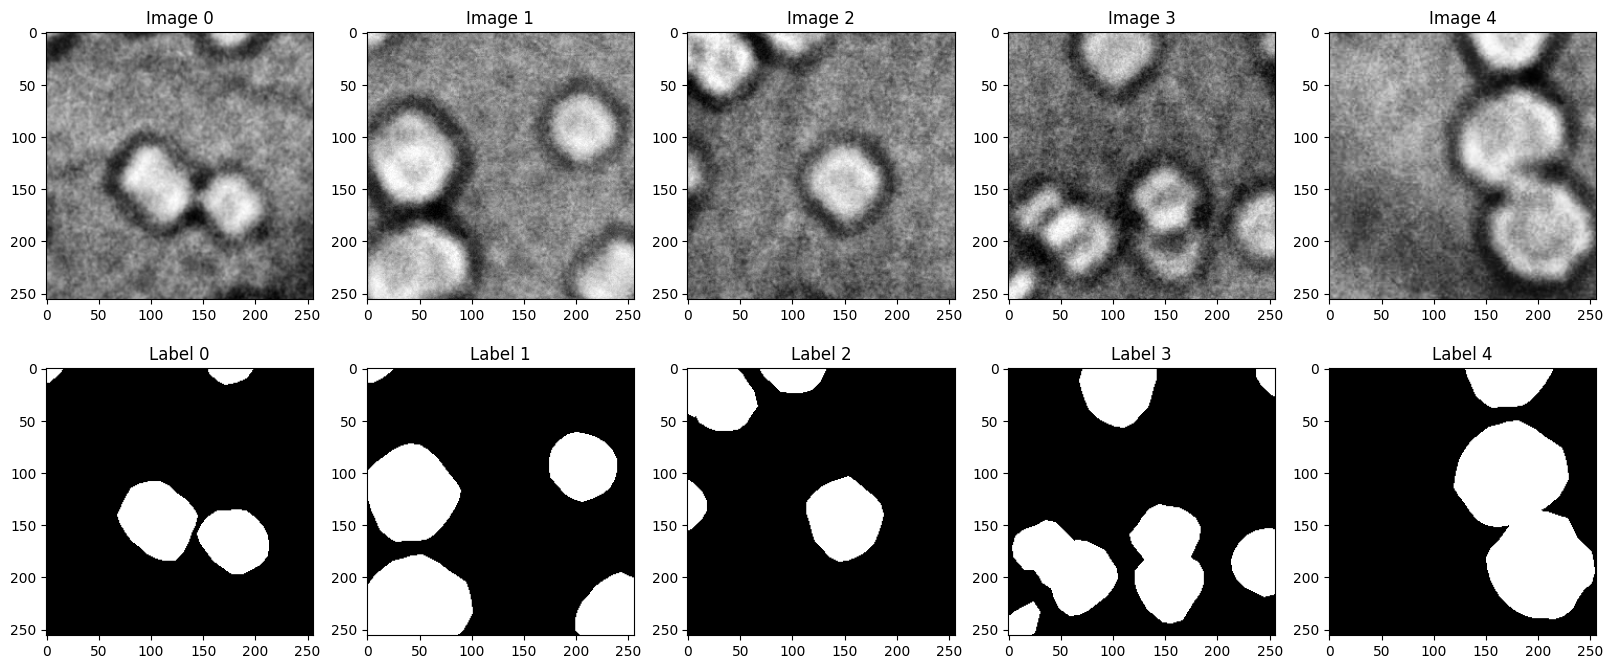

In [ ]:
fig = plt.figure(figsize=(20, 8))
for i in range(1, 6):
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(unet_img_aug[i-1, ...], cmap='gist_gray')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, 5, i+5)
    ax.imshow(unet_mask_aug[i-1, ...], cmap='gist_gray')
    ax.set_title('Label ' + str(i-1))

## Semantic segmentation

The following 2 cells allow uploading your own data for training. Uncomment the following cells and specify your download link and file path to load in training data using `!wget` or `!gdown` to download data from GitHub and Google Drive respectively.

Download training/test data:

In [ ]:
# Training data
#!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_unet_train_imgs.npy'
#!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_unet_train_labs.npy'

In [ ]:
# Load train/test data (this is a simple dataset generated just from a single image)
#images = np.load('DL_for_Microscopy_unet_train_imgs.npy')[:, None, ...][:-2]
#labels = np.load('DL_for_Microscopy_unet_train_labs.npy')[:-2]

# Let's use the last 2 image for validation during training
#images_test = np.load('DL_for_Microscopy_unet_train_imgs.npy')[:, None, ...][-2:]
#labels_test = np.load('DL_for_Microscopy_unet_train_labs.npy')[-2:]

Since we have already prepared the training data above, we do not need to upload data from external sources. We process the training data below. Notice that the **training iamges must have the no. of channels as its 2nd dimension**, hence why a `None` dimension is added for grayscale images. RGB images will have a size of 3 for their channel dimension.

In [ ]:
# Load train/test data (this is a simple dataset generated just from a single image)
images = unet_img_aug[:, None, ...][:-2]
labels = unet_mask_aug[:-2]

# Let's use the last 2 image for validation during training
images_test = unet_img_aug[:, None, ...][-2:]
labels_test = unet_mask_aug[-2:]

In [ ]:
# Show image and labels dimensions
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(30, 1, 256, 256) (30, 256, 256)
(2, 1, 256, 256) (2, 256, 256)


The training/test images and masks represent 4 separate numpy arrays with the dimensions (n_images, n_channels=1, image_height, image_width) for training/test images, and (n_images, image_height, image_width) for the associated masks (aka ground truth). The reason that our images have 4 dimensions, while our labels have only 3 dimensions is because of how the cross-entropy loss is calculated in PyTorch (see [here](https://pytorch.org/docs/stable/nn.html#nllloss)). Briefly, if you have multiple channels corresponding to different classes in your labeled data, you'll need to map your target classes to tensor indices. Here, we already did this for our training and test data during the preparation stage and so everything is ready for training.

Load data for making predictions on:

In [ ]:
# Data for prediction
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/test_image.png' # image
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/test_label.png' # labels

# Load data for prediction
expdata = plt.imread('test_image.png')
expdata_GT = plt.imread('test_label.png') # Ground truth

--2023-07-17 23:49:43--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/test_image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161901 (158K) [image/png]
Saving to: ‘test_image.png’

test_image.png      100%[===================>] 158.11K  --.-KB/s    in 0.006s  

2023-07-17 23:49:43 (25.8 MB/s) - ‘test_image.png’ saved [161901/161901]

--2023-07-17 23:49:43--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/test_label.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiti

Let's plot some of the training data:

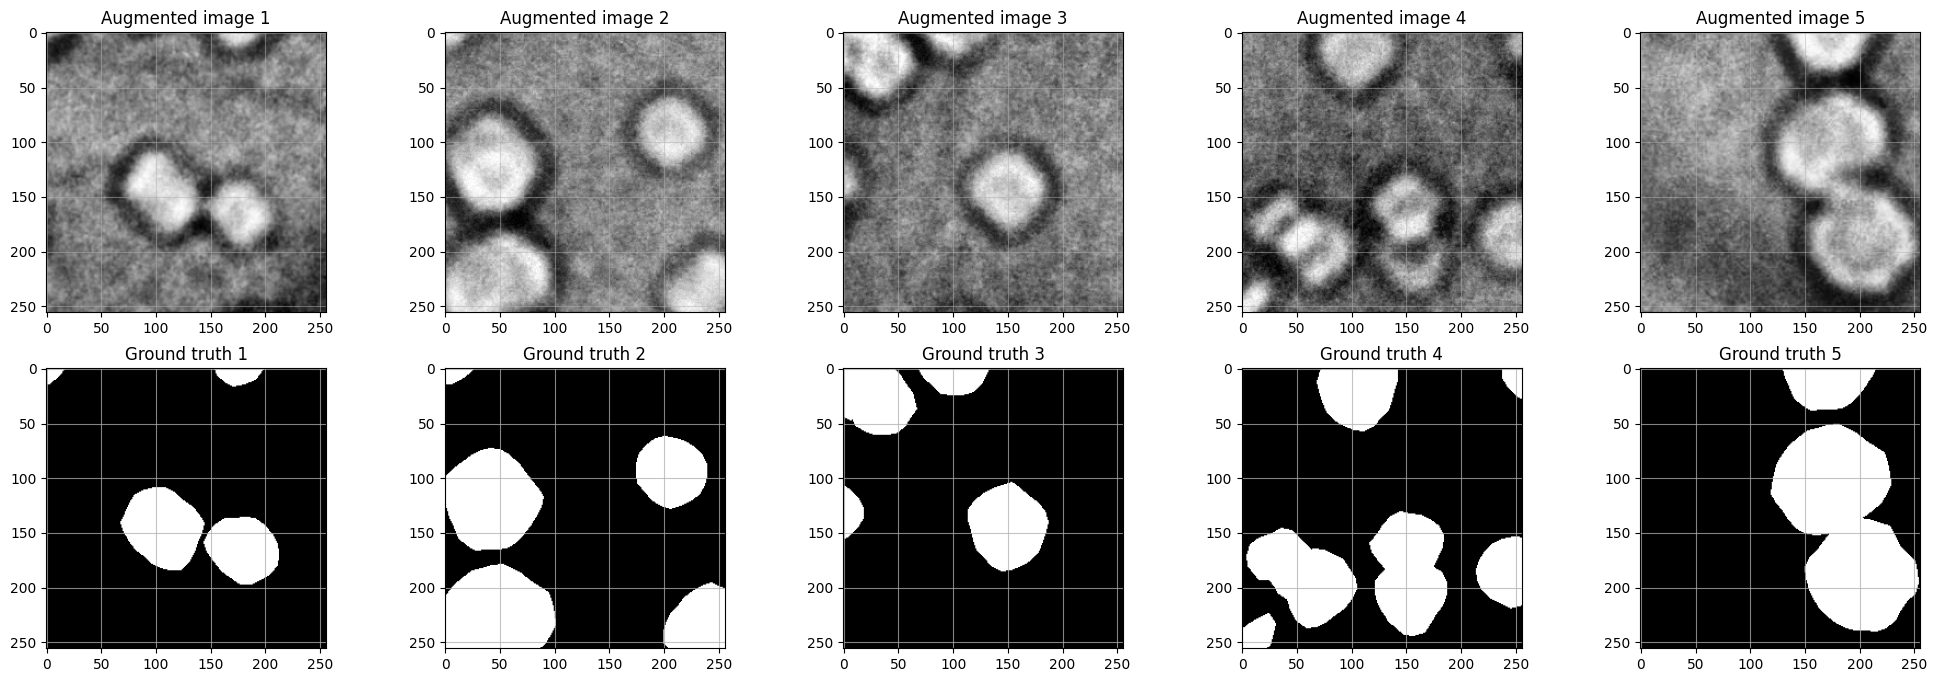

In [ ]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], cmap='gist_gray')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

The neural network will be trained to take the images in the top row (see plot above) as the input and to output clean images of circular-shaped "blobs" on a uniform background in the bottom row, from which one can identify the xy centers of atoms.

We are going to use a [UNet](https://en.wikipedia.org/wiki/U-Net)-like neural network for semantic segmentation. In the semantic segmentation tasks we aim at categorizing every pixel in the image. This is different form a regular image-level classification tasks, where we categorize the image as whole (e.g. this image has a cat/dog, etc.). Here's a nice illustration from this [free book](https://livebook.manning.com/book/deep-learning-with-pytorch/chapter-13/24):

<img src="https://drive.google.com/uc?export=view&id=18N4x3P0whH91OcpBOOkDprgWVo-36i34" width=800 px><br><br>

Initialize a nodel for semantic segmentation:

In [ ]:
model = aoi.models.Segmentor(nb_classes=1)

We can also "print" the neural network:

In [ ]:
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Train the initialized model:

The model dafaults to using Adam optimizer w/ learning rate=1e-3, BCE loss, and batch size of 32

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

/usr/local/lib/python3.10/dist-packages/atomai/utils/preproc.py:64: UserWarning: Adding a channel dimension of 1 to training labels
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/atomai/utils/preproc.py:69: UserWarning: Adding a channel dimension of 1 to test labels
  warnings.warn(


Epoch 1/300 ... Training loss: 0.8008 ... Test loss: 0.7575 ... Train Accuracy: 0.1701 ... Test Accuracy: 0.0824 ... GPU memory usage: 2279/40960
Epoch 100/300 ... Training loss: 0.1909 ... Test loss: 0.1661 ... Train Accuracy: 0.917 ... Test Accuracy: 0.9189 ... GPU memory usage: 2285/40960
Epoch 200/300 ... Training loss: 0.1002 ... Test loss: 0.0914 ... Train Accuracy: 0.9351 ... Test Accuracy: 0.9097 ... GPU memory usage: 2285/40960
Epoch 300/300 ... Training loss: 0.0923 ... Test loss: 0.0644 ... Train Accuracy: 0.9222 ... Test Accuracy: 0.9202 ... GPU memory usage: 2285/40960
Model (final state) evaluation loss: 0.0644
Model (final state) accuracy: 0.9202
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.066
Model (final state) accuracy: 0.927
Plotting training history


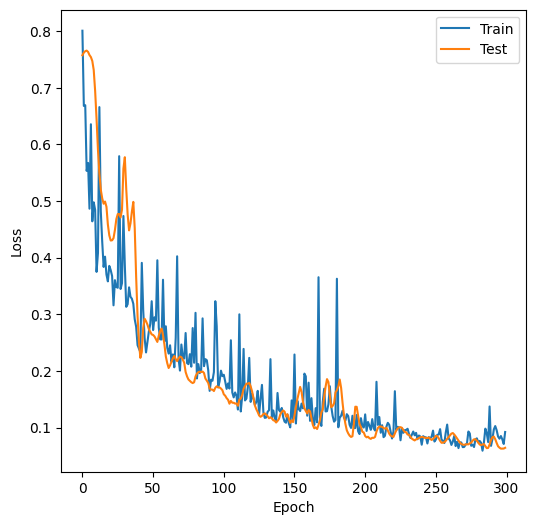

In [ ]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True, batch_size=2 # training parameters
)

### Predictions:

Now let's make a prediction on the testing image:

In [ ]:
# The output has 4 dimensions but only the middle 2 corresponds to the 2D mask hence [0,...,0]
nn_output = model.predict(expdata, compute_coords=False)[0, ..., 0]

Batch 1/1

Plot raw prediction:

Text(0.5, 1.0, 'Prediction results')

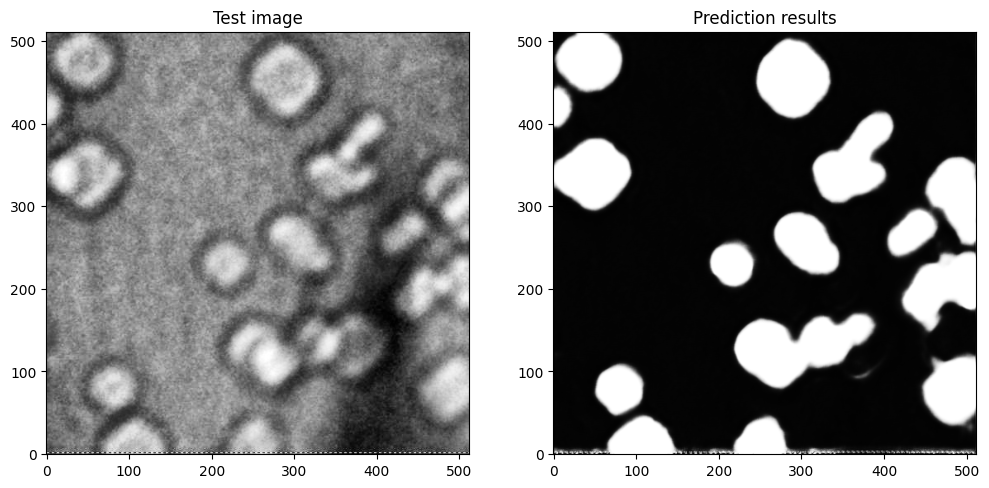

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax1.set_title('Test image')
ax2.imshow(nn_output, cmap='gray', origin="lower")
ax2.set_title('Prediction results')

Let's compare the predictions to the ground truth of the above image. The most common accuracy metric is the IoU score and it is implemented in PyTorch (TorchMetrics). (Image from Wikipedia)

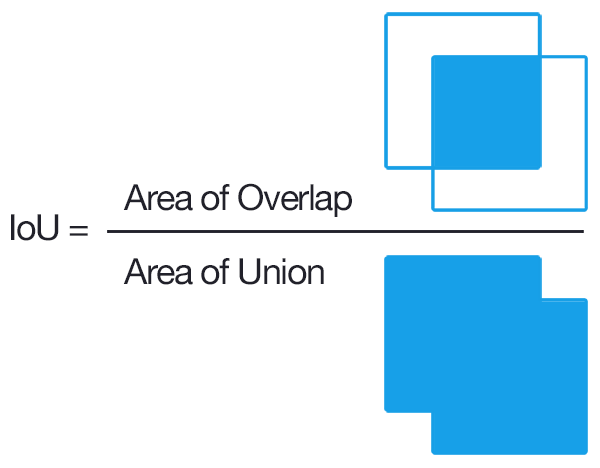

Install torchmetrics:

In [ ]:
import torch
!pip3 install torchmetrics
import torchmetrics
from torchmetrics import classification

IoU:  tensor(0.7127)


Calculate the IoU and show visual comparison:

IoU:  0.7126573324203491


Text(0.5, 1.0, 'Prediction results')

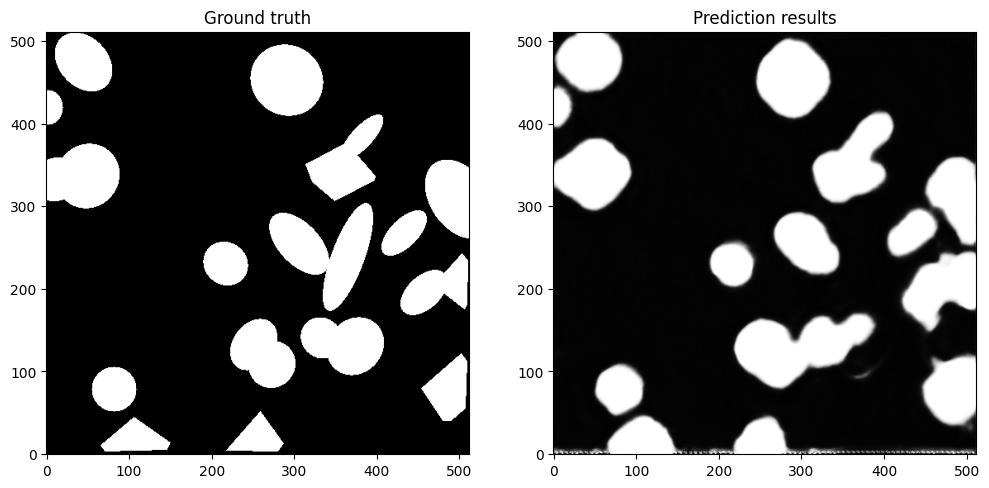

In [ ]:
metric = classification.BinaryJaccardIndex()
print('IoU: ', metric(torch.as_tensor(nn_output), torch.as_tensor(expdata_GT)).item())

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(expdata_GT, cmap='gray', origin="lower")
ax1.set_title('Ground truth')
ax2.imshow(nn_output, cmap='gray', origin="lower")
ax2.set_title('Prediction results')